Importing the necessary libraries to acquire and process data

In [ ]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as y_f
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
y_f.pdr_override()
from datetime import datetime

: 

Now lets extract some data from Yahoo Finance.
The adjusted close price of stocks to is used here to calculate the returns

In [2]:
startdate = datetime(2022,1,1)
enddate = datetime(2022,12,31)
#consider a portfolio consisting of tech stocks only
symbols  = ['XOM', 'GE', 'MSFT', 'BP','C','PG','WMT','PFE','HBC','TM']
data = pdr.get_data_yahoo(symbols,start=startdate, end=enddate)['Adj Close']
# print (data)

[*********************100%%**********************]  10 of 10 completed


Compute stock returns and and covariance matrix

In [3]:
stock_return = data.pct_change()
print (stock_return.round(4)*100)
mean_returns = stock_return.mean()
covariance_matrix = stock_return.cov()
print (mean_returns)
# print (covariance_matrix)

              BP     C    GE   HBC  MSFT   PFE    PG    TM   WMT   XOM
Date                                                                  
2022-01-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2022-01-04  4.31  0.78  3.25   NaN -1.71 -3.74  0.35  6.92 -1.83  3.76
2022-01-05 -0.63 -1.16  0.00  1.70 -3.84  2.02  0.45 -1.12  1.35  1.24
2022-01-06  1.55  3.28  0.58  2.74 -0.79 -1.42 -0.84  1.42 -0.28  2.35
2022-01-07  2.99  1.34  1.45  2.07  0.05  1.60 -0.06  0.35  0.95  0.82
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2022-12-23  1.74  0.61  0.02  0.00  0.23  0.37  0.28  0.10  0.20  2.64
2022-12-27  0.09  0.29  1.28  0.00 -0.74 -1.35  0.87 -0.71  0.03  1.39
2022-12-28 -1.31  0.52 -1.05  0.00 -1.03 -0.65 -1.29 -1.49 -1.75 -1.64
2022-12-29  0.35  1.21  2.17  0.00  2.76  1.04  0.41  2.45  0.61  0.76
2022-12-30  0.66  0.15  0.05  0.00 -0.49 -0.18 -0.68 -0.60 -0.25  1.01

[251 rows x 10 columns]
BP      0.001402
C      -0.000959
GE     -0.000293
H

Set the iteration count for montecarlo simulation.
The parmeters that are used for prediction will be returns, standard deviation, Sharpe ratio.
All the results are stored in sim_result array  


In [4]:
iteration = 10000
sim_result = np.zeros((3+len(symbols),iteration))
for i in range(iteration):
        #Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(len(symbols)))
        weights /= np.sum(weights)

        #Saving the weights
        for j in range(len(weights)):
                sim_result[j+3,i] = weights[j]

        #Calculate the return and standard deviation for every iteration
        net_return = np.sum(mean_returns * weights)
        standard_dev = np.sqrt(np.dot(weights.T,np.dot(covariance_matrix, weights)))
        sim_result[0,i]=net_return
        sim_result[1,i]=standard_dev

        #Calculate Sharpe ratio
        sim_result[2,i] = sim_result[0,i] / sim_result[1,i]


The results for n iterations is obtained. We will now require to process it to get an optimised result. The accuracy increases with the number of iterations.

In [5]:
Data = pd.DataFrame(sim_result.T,columns=['RETURNS','STANDARD_DEVIATION','SHARPE',"Weight_"+symbols[0],"Weight_"+symbols[1],"Weight_"+symbols[2]
                                          ,"Weight_"+symbols[3],"Weight_"+symbols[4],"Weight_"+symbols[5],"Weight_"+symbols[6],"Weight_"+symbols[7],
                                          "Weight_"+symbols[8],"Weight_"+symbols[9]])
# print (Data.head())
# print (Data.tail())

The portfolio with the highest sharpe will now be considered for further analysis.

In [6]:
max_sharpe = Data.iloc[Data['SHARPE'].idxmax()]
print(max_sharpe)

RETURNS               0.000889
STANDARD_DEVIATION    0.012933
SHARPE                0.068769
Weight_XOM            0.120450
Weight_GE             0.022782
Weight_MSFT           0.037346
Weight_BP             0.050347
Weight_C              0.024509
Weight_PG             0.134264
Weight_WMT            0.117697
Weight_PFE            0.073555
Weight_HBC            0.069697
Weight_TM             0.349354
Name: 7211, dtype: float64


Assuming starting amount to be 1000$ and a normal distribution we will run another montecarlo simulation over a time horizon of 30 years to analyze the performance of the portfolio

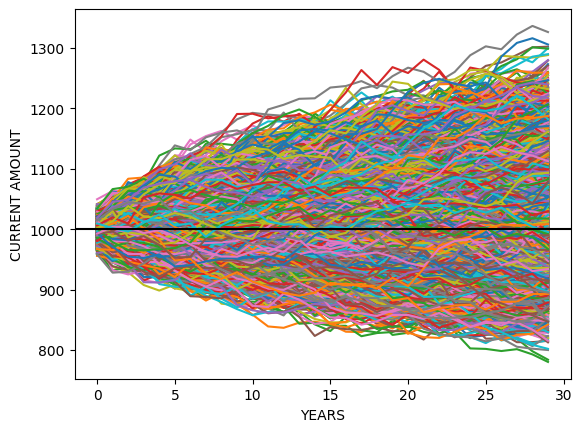

Number of successfull scenarios:  6294
Percentage Success is:  62.94 %


In [7]:
iteration2=10000
horizon=30
Final_Results = np.zeros((iteration2, horizon))
initial=1000
profit=0
for i in range(iteration2):
    current = initial
    X=[]
    Y=[]
    for year in range(horizon):
        current = current * (1 + np.random.normal(max_sharpe['RETURNS'], max_sharpe['STANDARD_DEVIATION']))
        Final_Results[i,year] = current
        X.append(year)
        Y.append(current)
    if current>initial:
        profit+=1
    plt.plot(X,Y)
plt.axhline(y = 1000, color = 'k', linestyle = '-')
plt.xlabel("YEARS")
plt.ylabel("CURRENT AMOUNT")
plt.show()
print("Number of successfull scenarios: ",profit)
print("Percentage Success is: ",(profit/iteration2)*100,"%")

Plotting the histogram

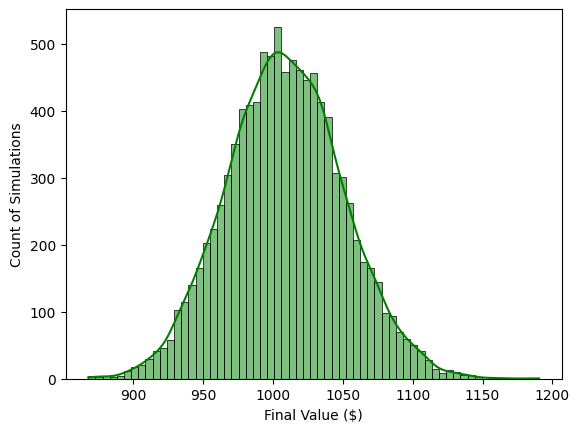

In [10]:
sbn.histplot(Final_Results.T[9],kde=True,color='g')
plt.xlabel('Final Value ($)')
plt.ylabel('Count of Simulations')
plt.show()


The portfolio with the minimun standard deviation will now be considered for further analysis.

In [11]:
min_stddeviation = Data.iloc[Data['STANDARD_DEVIATION'].idxmin()]
print(min_stddeviation)

RETURNS              -0.000080
STANDARD_DEVIATION    0.009469
SHARPE               -0.008487
Weight_XOM            0.002701
Weight_GE             0.077233
Weight_MSFT           0.003517
Weight_BP             0.246491
Weight_C              0.061178
Weight_PG             0.037672
Weight_WMT            0.187736
Weight_PFE            0.090812
Weight_HBC            0.174491
Weight_TM             0.118169
Name: 574, dtype: float64


Assuming starting amount to be 1000$ and a normal distribution we will run another montecarlo simulation over a time horizon of 30 years to analyze the performance of the portfolio

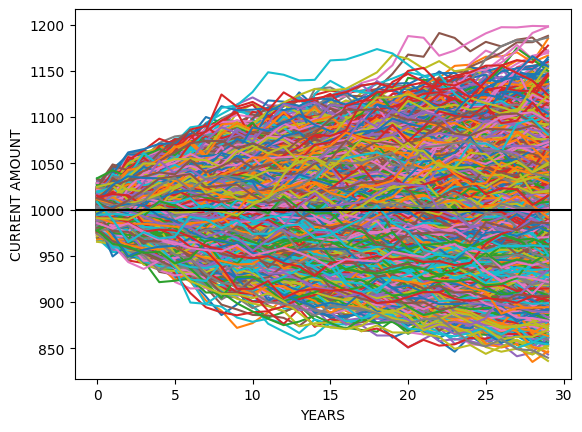

Number of successfull scenarios:  4699
Percentage Success is:  46.989999999999995 %


In [12]:
iteration2=10000
horizon=30
Final_Results = np.zeros((iteration2, horizon))
initial=1000
profit=0
for i in range(iteration2):
    current = initial
    X=[]
    Y=[]
    for year in range(horizon):
        current = current * (1 + np.random.normal(min_stddeviation['RETURNS'], min_stddeviation['STANDARD_DEVIATION']))
        Final_Results[i,year] = current
        X.append(year)
        Y.append(current)
    if current>initial:
        profit+=1
    plt.plot(X,Y)
plt.axhline(y = 1000, color = 'k', linestyle = '-')
plt.xlabel("YEARS")
plt.ylabel("CURRENT AMOUNT")
plt.show()
print("Number of successfull scenarios: ",profit)
print("Percentage Success is: ",(profit/iteration2)*100,"%")

Plotting the histogram

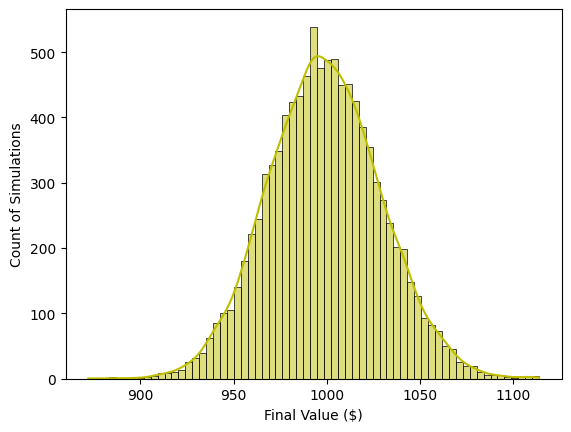

In [17]:
sbn.histplot(Final_Results.T[9],kde=True,color='y')
plt.xlabel('Final Value ($)')
plt.ylabel('Count of Simulations')
plt.show()
